In [1]:
import pandas as pd

pd.set_option("display.width", 180)
pd.set_option("display.max_columns", 100)

In [8]:
from pathlib import Path

CSV_PATH = Path("./open/train.csv")
OUTPUT_DIR = CSV_PATH.parent / "erd"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

Matplotlib is building the font cache; this may take a moment.


>> Loading CSV...

===== [기본 정보] =====
shape: (30858, 10)

[컬럼/타입]
ID                     object
age                   float64
gender               category
tenure                float64
frequent              float64
payment_interval      float64
subscription_type    category
contract_length         int64
after_interaction     float64
support_needs           Int64
dtype: object

[상위 5행]
            ID   age gender  tenure  frequent  payment_interval subscription_type  contract_length  after_interaction  support_needs
0  TRAIN_00000  54.0      F    47.0      22.0               8.0            member               90               25.0              0
1  TRAIN_00001  30.0      M    16.0      15.0               5.0               vip              360               23.0              0
2  TRAIN_00002  29.0      M     8.0      30.0              21.0              plus               30               21.0              0
3  TRAIN_00003  38.0      F    38.0      23.0              10.0               

IndexError: index 0 is out of bounds for axis 0 with size 0

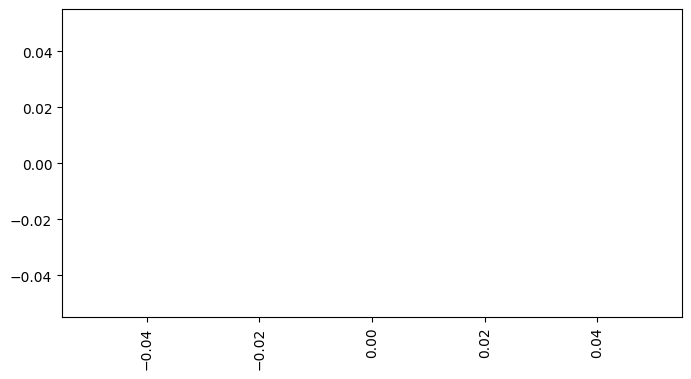

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

TARGET_COL = "support_needs"          # 이진 타깃(0/1)로 가정
ID_COL = "ID"                         # 식별자
CANDIDATE_CATEG_COLS = ["gender", "subscription_type"]
# 숫자 열은 자동 감지 + 아래 리스트를 우선 포함
CANDIDATE_NUM_COLS = [
    "age", "tenure", "frequent", "payment_interval",
    "contract_length", "after_interaction"
]

# =========================
# 2) 유틸
# =========================
def savefig(name, tight=True):
    if tight:
        plt.tight_layout()
    filepath = OUTPUT_DIR / f"{name}.png"
    plt.savefig(filepath, dpi=140)
    plt.close()
    return filepath

def maybe_category(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("category")
    return df

def coerce_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def top_correlations(df, target, k=10):
    num_df = df.select_dtypes(include=[np.number])
    if target not in num_df.columns:
        return pd.Series(dtype=float)
    corrs = num_df.corr(numeric_only=True)[target].drop(labels=[target]).dropna()
    return corrs.abs().sort_values(ascending=False).head(k).rename("abs_corr").to_frame()

# =========================
# 3) 로드/전처리
# =========================
print(">> Loading CSV...")
df = pd.read_csv(CSV_PATH)

# 타입 정리
if ID_COL in df.columns:
    df[ID_COL] = df[ID_COL].astype(str)

df = maybe_category(df, CANDIDATE_CATEG_COLS)
df = coerce_numeric(df, CANDIDATE_NUM_COLS)

# TARGET 타입 보정(이진 가정)
if TARGET_COL in df.columns:
    # 문자열/float -> 0/1
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce").astype("Int64")

# =========================
# 4) 기본 정보
# =========================
print("\n===== [기본 정보] =====")
print(f"shape: {df.shape}")
print("\n[컬럼/타입]")
print(df.dtypes)

print("\n[상위 5행]")
print(df.head())

# 고유값 수
nunique = df.nunique(dropna=True).sort_values(ascending=False)
nunique.to_csv(OUTPUT_DIR / "nunique.csv")
print("\n[각 컬럼 고유값 수 Top 15]")
print(nunique.head(15))

# =========================
# 5) 결측치
# =========================
print("\n===== [결측치 요약] =====")
na_cnt = df.isna().sum().sort_values(ascending=False)
na_rate = (na_cnt / len(df)).rename("na_rate")
na_summary = pd.concat([na_cnt.rename("na_cnt"), na_rate], axis=1)
na_summary.to_csv(OUTPUT_DIR / "missing_summary.csv")
print(na_summary[na_summary["na_cnt"] > 0].head(20))

plt.figure(figsize=(8, 4))
(na_cnt[na_cnt > 0]).plot(kind="bar")
plt.title("Missing Values Count (Non-zero only)")
plt.ylabel("count")
savefig("missing_bar")

# =========================
# 6) 기술통계
# =========================
print("\n===== [기술통계] =====")
desc_num = df.select_dtypes(include=[np.number]).describe().T
desc_num.to_csv(OUTPUT_DIR / "describe_numeric.csv")
print(desc_num.head(10))

desc_cat = df.select_dtypes(include=["category", "object"]).describe().T
desc_cat.to_csv(OUTPUT_DIR / "describe_categorical.csv")

# =========================
# 7) 수치형 분포/박스플롯
# =========================
num_cols = [c for c in CANDIDATE_NUM_COLS if c in df.columns]
num_cols += [c for c in df.select_dtypes(include=[np.number]).columns if c not in num_cols and c != TARGET_COL]

for col in num_cols:
    # 히스토그램
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    savefig(f"dist_{col}")

    # 박스플롯
    plt.figure(figsize=(5, 3.5))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
    savefig(f"box_{col}")

# =========================
# 8) 범주형 분포
# =========================
cat_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()
if ID_COL in cat_cols:
    cat_cols.remove(ID_COL)

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    vc = df[col].value_counts(dropna=False)
    sns.barplot(x=vc.index.astype(str), y=vc.values)
    plt.title(f"Counts: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.xticks(rotation=30, ha="right")
    savefig(f"count_{col}")

# =========================
# 9) 상관관계(수치형)
# =========================
if len(num_cols) > 1:
    plt.figure(figsize=(8, 6))
    corr = df[num_cols + ([TARGET_COL] if TARGET_COL in df.columns else [])].corr(numeric_only=True)
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap")
    savefig("corr_heatmap")

    # 타깃과의 상관 Top-K
    if TARGET_COL in df.columns and df[TARGET_COL].notna().any():
        topk = top_correlations(df, TARGET_COL, k=min(10, len(num_cols)))
        topk.to_csv(OUTPUT_DIR / "top_corr_with_target.csv")
        print("\n[타깃과 절대 상관 Top-K]")
        print(topk)

# =========================
# 10) 타깃 분석(이진 타깃 가정)
# =========================
if TARGET_COL in df.columns and df[TARGET_COL].notna().any():
    print("\n===== [타깃 분포] =====")
    tgt_vc = df[TARGET_COL].value_counts(dropna=True).sort_index()
    print(tgt_vc)
    plt.figure(figsize=(4, 4))
    sns.barplot(x=tgt_vc.index.astype(str), y=tgt_vc.values)
    plt.title(f"Target Distribution: {TARGET_COL}")
    plt.xlabel(TARGET_COL)
    plt.ylabel("count")
    savefig("target_dist")

    # 수치형: 타깃별 분포
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.kdeplot(data=df, x=col, hue=TARGET_COL, common_norm=False)
        plt.title(f"{col} by {TARGET_COL}")
        savefig(f"kde_{col}_by_target")

    # 범주형: 타깃 비율(positive rate)
    cat_summary_frames = []
    for col in cat_cols:
        tmp = (
            df.groupby(col, dropna=False)[TARGET_COL]
              .agg(['count', 'mean'])
              .rename(columns={'mean': f'{TARGET_COL}_rate'})
              .sort_values(f'{TARGET_COL}_rate', ascending=False)
        )
        tmp.to_csv(OUTPUT_DIR / f"target_rate_by_{col}.csv")
        cat_summary_frames.append(tmp)

        plt.figure(figsize=(7, 4))
        sns.barplot(
            x=tmp.index.astype(str),
            y=tmp[f'{TARGET_COL}_rate'].values
        )
        plt.title(f"{TARGET_COL} rate by {col}")
        plt.xlabel(col)
        plt.ylabel("rate")
        plt.xticks(rotation=30, ha="right")
        savefig(f"target_rate_by_{col}")

# =========================
# 11) 간단한 이상치(IQR) 체크
# =========================
iqr_report = []
for col in num_cols:
    s = df[col].dropna()
    if s.empty:
        continue
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    out_rate = ((s < lower) | (s > upper)).mean()
    iqr_report.append((col, float(lower), float(upper), float(out_rate)))

iqr_df = pd.DataFrame(iqr_report, columns=["col", "lower_bound", "upper_bound", "outlier_rate"])
iqr_df.sort_values("outlier_rate", ascending=False, inplace=True)
iqr_df.to_csv(OUTPUT_DIR / "iqr_outlier_report.csv", index=False)
print("\n===== [IQR 이상치 비율 Top 10] =====")
print(iqr_df.head(10))

# =========================
# 12) 예시: 도메인별 교차(필요 시 수정)
# =========================
# 성별·구독유형 조합별 타깃율
if all(c in df.columns for c in ["gender", "subscription_type", TARGET_COL]):
    cross = (
        df.pivot_table(
            index="gender", columns="subscription_type",
            values=TARGET_COL, aggfunc="mean"
        )
    )
    cross.to_csv(OUTPUT_DIR / "target_rate_gender_by_subscription.csv")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cross, annot=True, fmt=".3f", cmap="Blues")
    plt.title(f"{TARGET_COL} rate by gender x subscription_type")
    savefig("target_rate_heatmap_gender_subscription")

print(f"\n완료! 결과 파일 저장 위치: {OUTPUT_DIR.resolve()}")